In [1]:
#Fix Variance and utility arrays for different strategies

import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
from numpy import log as ln
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
import sympy as sp
from sympy import symbols, Eq, solve
import json
from time import process_time
import sys
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Overall Model Parameters

# Model Functions

In [28]:
#Fixed parameters
sensitivity_steps = 1 #Number of parameter values scanned for sensitivity parameter specified below
simulations = 10
annual_decisions = 4 #Number of times an agent is evaluating strategy on average
households = 100
time = 20000
mu_farm = 260.9 #For cereal crops only 176.5 #For all crops 260.93 #Previously mu_farm = 163.4
farm_k = 0.798 #For cereal crops only 1.31 #For all crops 0.798 #For STD = 321; previously k = 0.808 #Shape factor for farming income distribution (Weibull)
max_farm = 2500 #For cereal crops only: 732.1 #For combined: 2500 #99th percentile of farm income/cycle (in USD) to truncate Weibull - based on CVFS total revenues
eta = 0.9 #Proportion of full farm income that is still earned by households engaging in migration
cost_farm = 221.3 #170


migration_type = 'International'

if migration_type == 'International':
    mu_migrate =   600.8 #Without 0's 1016 #CVFS average with 0s included 872.2 #664.9 from CVFS Data #600.8 from Shrestha data - combined #For intl only 872.2 
    var_migrate = 648.8 ** 2 #Without 0's 1083 ** 2 #From CVFS data with 0's 825.8 ** 2 #For intl only: 825.8 ** 2 #For combined: 648.8 ** 2 #Oriignal 998.2 ** 2
    cost_migrate = 700.6 #Weighted Avg from Shrestha 700.6 #For intl only:1133 #500
    
elif migration_type == 'Local':
    mu_migrate = 200 
    var_migrate = 190 ** 2 
    cost_migrate = 62.5

else: 
    raise ValueError ('Migration type improperly specified')
    

subsidy = 0 #Subsidy on cost of insurance premium
matching = 0 #Amount of matching dollars government contributes to revenue-sharing pools, per hh per cycle

beta = 0.2 #Proportion of income that is shared in collective
objective_drought = 0.2 #Presumed drought risk in 2021, to set income threshold for drought vs. non-drought year
p_drought = 0.35 #This can vary based on severity of climate risk that is to be modelled
p_cov = 0.35 #Pearson's correlation coefficient for farming (i.e. covariate risk)
rho_mig = 0.0 #Pearson's correlation coefficient for farming and migration income streams
init_insure = 0.00 #Initial adopters of insurance

discount_rate = 0.2
time_horizon = 10 #Number of cycles across which a household evaluates options

utility_function = 'Self-Interested'

risk_factor = 0.5
altruism_factor = 0.0 #Degree to which individuals account for other households' utility, should range from [0,1]
max_altruism = 1 #Scalar by which others' utilities are multiplied, before applying altruism factor. Can take on any non-zero number. 1 = household caring about the sum of other households equally to their own for altruism factor = 1. 

k = 0.0 #Probability of an agent following another agent
sel_strength = 27.73 #Strength of selection effect; 27.73 gives 80% change of switching for relative utility gap of 5%
mutation_rate= 1 /households #1 / households



## Calculating Variances of Drought and Non-Drought Income Distributions

In [3]:
#Calculate variance of truncated distributions (for drought vs. non-drought distributions)
def trunc_var(income_sample, mu):
    running_var = 0
    N = len(income_sample)
    for i in range(N):
        running_var += (income_sample[i] - mu) ** 2
    
    var = running_var / (N - 1)
    
    return var

#Define drought and non-drought portions of farming income distribution
def farm_drought_0(adj_k, adj_scale, p_drought, max_farm):
    
    new_dist = adj_scale * np.random.weibull(adj_k, size=10000)
    adj_income = list(np.sort(new_dist))
    
    adj_drought_index = int(p_drought * len(adj_income))
    adj_nondrought_incomes = np.array(adj_income[adj_drought_index:len(adj_income)]).astype(float)
    
    if p_drought == 0:
        adj_drought_incomes = adj_nondrought_incomes
    else:
        adj_drought_incomes = np.array(adj_income[0:adj_drought_index]).astype(float)
    
    mu_farm_drought = np.average(adj_drought_incomes)
    mu_farm_nd = np.average(adj_nondrought_incomes)
    mu_farm = np.average(np.array(adj_income).astype(float))
    
    var_drought = trunc_var(adj_drought_incomes, mu_farm)
    var_nd = trunc_var(adj_nondrought_incomes, mu_farm)
    
    uninsured_var = trunc_var(adj_income, mu_farm)
    
    #Adjusting income distribution during drought years for insurance holders
    payout_distribution = adj_drought_incomes + (mu_farm_nd - mu_farm_drought)
    payout_var = trunc_var(payout_distribution, mu_farm_nd) 
    insured_var = p_drought * payout_var + (1 - p_drought) * var_nd
    
    return mu_farm_drought, mu_farm_nd, uninsured_var, insured_var

#Adjust Weibull distribution parameters based on drought risk
def wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm):
    
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))
    income_distribution = scale * np.random.weibull(farm_k, size=1000000)
    sorted_income = list(np.sort(income_distribution))
    drought_index = int(objective_drought * len(sorted_income)) - 1
    drought_threshold = sorted_income[drought_index]
        
    #Identify value of Weibull cdf that represents 99.99 percentile
    last_percent = max_farm
    
    x, y = symbols('x y')
    eq1 = Eq(1 - sp.exp(-(last_percent/ y) ** x), 0.9999)
    eq2 = Eq(1 - sp.exp(-(drought_threshold / y) ** x), p_drought)
    
    adj_k, adj_scale = solve((eq1, eq2), (x,y))[-1]
    
    return adj_k, adj_scale


#Calculate variance from Weibull distribution parameters
def wei_var(mu, k):
    scale = (mu / math.gamma(1 + 1 / k))
    variance = scale ** 2 * (math.gamma(1 + 2 / k) - (math.gamma(1 + 1 / k)) ** 2)
    return variance

def wei_scale(mean, shape):
    scale = (mean / math.gamma(1 + 1 / shape))
    
    return scale

#Function that returns Weibull shape parameter (k) from mean and std dev
def wei_shape(mean, std_dev):
    k = (std_dev / mean) ** -1.086
    
    return k

def lognorm_factors(mean, std_dev):
    mu = np.log(mean / math.sqrt(1 + std_dev ** 2 / mean ** 2))
    sigma = math.sqrt(np.log(1 + std_dev ** 2 / mean ** 2))
    
    return mu, sigma

#Function to calculate NPV of an array
def npv_calc(array, time_horizon, discount_rate):
    npv = 0
    
    for i in range(time_horizon):
        npv += array[i] / ((1 + discount_rate) ** i)
        
    return npv


## Calculating Incomes and NPV of Income

In [4]:
#Calculate NPV based on annual income, costs, and discount rate
def income_horizon(time_horizon, strategy, strategy_cost, farm_income, shared_income, remittances, migration_cost, discount_rate):
    income = np.zeros(time_horizon)
    costs = np.zeros(time_horizon)
    
    #Accounting for different costs/income in initial time step of migration
    if 'Migrate' in strategy:
        costs[0] = strategy_cost
        income[0] = farm_income + shared_income
        for i in range(1, time_horizon):
            income[i] = farm_income + remittances + shared_income
            costs[i] = strategy_cost - migration_cost #Becuase strategy_costs captures costs related to all strategy components
    else:
        for i in range(0, time_horizon):
            costs[i] = strategy_cost
            income[i] = farm_income + remittances + shared_income
        
    return income, costs
        

# Calculate expected income from strategy options as a function of strategy distribution
def income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate):
    income_array = {key : 0 for key in strategy_names}
    cost_array = {key : 0 for key in strategy_names} 
    expected_payoffs = {key : 0 for key in strategy_names} 
    
    #Income generated by own household
    farm_income = {'Farm': p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd, 
                     'FarmMigrate': eta * (p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd), 
                     'Farm+Share': p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd, 
                     'FarmMigrate+Share': eta * (p_drought * mu_farm_drought + (1 - p_drought) * mu_farm_nd), 
                     'Farm+Ins': mu_farm_nd, 
                     'FarmMigrate+Ins': mu_farm_nd * eta, 
                     'Farm+Share+Ins': mu_farm_nd, 
                     'FarmMigrate+Share+Ins': mu_farm_nd * eta}
    
    remittances = {'Farm': 0, 
                   'FarmMigrate': mu_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': mu_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': mu_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': mu_migrate}
    
    shared_pool = 0
    shared_dist = 0
    for item in strategy_names:
        #Check whehter we should adjust how much migrant households contribute/receive in shared income
        if 'Share' in item:
            shared_pool += beta * frequency_dist[item] * farm_income[item]
            shared_dist += frequency_dist[item]
    
    if shared_dist == 0:
        household_share = 0
    else:
        household_share = (shared_pool + shared_dist * matching) / shared_dist
        
    shared_income_received = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': household_share, 
                   'FarmMigrate+Share': household_share, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': household_share, 
                   'FarmMigrate+Share+Ins': household_share}
    
    costs = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm + cost_migrate, 
            'Farm+Share': cost_farm + beta * farm_income['Farm+Share'], 
            'FarmMigrate+Share': cost_farm + cost_migrate + beta * farm_income['FarmMigrate+Share'], 
            'Farm+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought) - subsidy, 
            'FarmMigrate+Ins': cost_farm + cost_migrate + p_drought * eta * (mu_farm_nd - mu_farm_drought) - subsidy, 
            'Farm+Share+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought) + beta * farm_income['Farm+Share+Ins'] - subsidy, 
            'FarmMigrate+Share+Ins': cost_farm + cost_migrate + p_drought * eta * (mu_farm_nd - mu_farm_drought) + beta * farm_income['FarmMigrate+Share+Ins'] - subsidy}
    
    for item in strategy_names:
        income_array[item], cost_array[item] = income_horizon(time_horizon, item, costs[item], farm_income[item], shared_income_received[item], remittances[item], cost_migrate, discount_rate)
        expected_payoffs[item] = income_array[item] - cost_array[item]
    
    return expected_payoffs
        

## Calcluating Variances and NPV of Variance

In [5]:
#NOTE - ensure combined variance accounts for covariance between all players of the same strategy

#Variance calculation - calls upon combined_variance and npv_variance functions
def variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, p_cov, strategy_names, time_horizon, discount_rate):
    std_array = {key : 0 for key in strategy_names}
    
    var_farm = wei_var(mu_farm, farm_k)
    
    #Farming income variance, before accounting for shared pool
    base_farm_variance = {'Farm': uninsured_var, 
                   'FarmMigrate': (eta ** 2) * uninsured_var, 
                   'Farm+Share': uninsured_var, 
                   'FarmMigrate+Share': (eta ** 2) * uninsured_var, 
                   'Farm+Ins': insured_var, 
                   'FarmMigrate+Ins': (eta ** 2) * insured_var, 
                   'Farm+Share+Ins': insured_var, 
                   'FarmMigrate+Share+Ins': (eta ** 2) * insured_var} 
    
    
    #Remittance income variance before accounting for shared pool
    base_remittance_variance = {'Farm': 0, 
                   'FarmMigrate': var_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': var_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': var_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': var_migrate}
    
    
  
    #for key in strategy_names:
        #base_combined_var[key] = base_farm_variance[key] + base_remittance_variance[key] + 2 * rho_mig * math.sqrt(base_farm_variance[key]) * math.sqrt(base_remittance_variance[key])
        
    
    #Calculating variance of shared strategies
    pool_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            pool_dist += frequency_dist[item]
    
    total_farm_variance = {key: 0 for key in strategy_names}
    total_variance = {key : 0 for key in strategy_names}
    total_std = {key : 0 for key in strategy_names}
    
    for item in strategy_names:
        if 'Share' in item and frequency_dist[item] != 0:
            total_farm_variance[item] = combined_variance(beta, pool_dist, households, p_cov, base_farm_variance, item, frequency_dist, strategy_names)

        else:
            total_farm_variance[item] = base_farm_variance[item]   
        
        #Adding farm and remittance variances
        total_variance[item] = total_farm_variance[item] + base_remittance_variance[item]
        total_std[item] = math.sqrt(total_variance[item])
        
        #Calculates NPV of Standard Deviation
        std_array[item] = std_horizon(time_horizon, item, total_std, discount_rate)
    return std_array

#Function that calculates combined variance for sharing pool between income streams A and B, given correlation coefficient p_cov
def combined_variance(beta, pool_dist, households, p_cov, individual_variance, strategy_a, frequency_dist, strategy_names):
    #Note - strategy_a reflects the strategy that is being played by the household. This is important for keeping track of how many other households are playing the same strategy in the shared pool. 
    
    #Converting proportion of participants in pool to an integer
    pool_hh = pool_dist * households
    #Factors for kept, shared, and received variances
    kept = (1 - beta) #Factor for portion of a household's income that is kept (i.e. not shared with pool)
    shared = beta / pool_hh #Should a square root be in the denominator? Factor for portion of a household's income that is initially shared to pool and returned to household 
    
    #Variance and Covariance of kept and shared portions from household's own income
    own_covariance = (kept ** 2 + shared ** 2  + (2 * kept * shared)) * individual_variance[strategy_a]
    
    #Creating Covariance matrix
    shared_strategies = []
    for name in strategy_names:
        if 'Share' in name:
            shared_strategies.append(name)
    
    covariance_matrix = {key : {} for key in shared_strategies}
    
    for row in shared_strategies:
        #Note - what about covariance in farm incomes between insured and non-insured strategies?
        covariance_matrix[row] = {column: p_cov for column in shared_strategies}
        
    #Covariance between a household's kept income (strategy_a) and income received from rest of the pool (item)
    contributed_cov = 0
    for item in shared_strategies:
        if item == strategy_a and frequency_dist[strategy_a] > 0:
            contributed_cov += 2 * covariance_matrix[strategy_a][item] * kept * beta * (frequency_dist[item] * households - 1) / pool_hh * math.sqrt(individual_variance[strategy_a]) * math.sqrt(individual_variance[item])

        else:
            contributed_cov += 2 * covariance_matrix[strategy_a][item] * kept * beta * frequency_dist[item] * households / pool_hh * math.sqrt(individual_variance[strategy_a]) * math.sqrt(individual_variance[item])
        
    
    #Variance and Covariance between income from other contributors within a pool that is received by a household
    pool_var = 0
    pool_cov = 0
    for i, row in enumerate(shared_strategies):
        X_i = frequency_dist[row] * households #Number of households playing strategy "row", a.k.a strategy "i"
        
        #Covariance of contributed amounts for same strategy
        if row == strategy_a and frequency_dist[strategy_a] > 0:
            pool_var += ((X_i - 1) * beta ** 2 / (pool_hh) ** 2 * individual_variance[row] + 2 * X_i * (X_i - 1) * covariance_matrix[row][row] * beta ** 2 / (2 * (pool_hh) ** 2) * individual_variance[row])
       
        elif frequency_dist[row] > 0:
            pool_var += ((X_i * beta ** 2 / (pool_hh) ** 2 * individual_variance[row]) + 2 * X_i * (X_i - 1) * covariance_matrix[row][row] * beta ** 2 / (2 * (pool_hh) ** 2) * individual_variance[row])
        
        #Covariance of contributed amounts between different strategies
        for j, column in enumerate(shared_strategies):
            if j < i:
                X_j = frequency_dist[column] * households #Number of households playing strategy "column", a.k.a strategy "j"
                pool_cov += ((2 * beta ** 2 * covariance_matrix[row][column] * X_i * X_j) / (2 * (pool_hh) ** 2) * math.sqrt(individual_variance[row]) * math.sqrt(individual_variance[column]))

    total_covariance = own_covariance + contributed_cov + pool_var + pool_cov
    
    return total_covariance

#Adjusted NPV calculation for standard deviation to account for delay in migration remittances
def std_horizon(time_horizon, strategy, std, discount_rate):
    annual_std = np.zeros(time_horizon)
    
    if 'Migrate' in strategy:
        equivalent = strategy.replace('Migrate', '')
        annual_std[0] = std[equivalent]
        for i in range(1, time_horizon):
            annual_std[i] = std[strategy]
    
    else:
        for i in range(0, time_horizon):
            annual_std[i] = std[strategy]
    
    return annual_std


            

In [6]:
#Alternative Utility Calculation

def utility_calc(strategy_names, households, strategy_x, strategy_y, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, prior_distribution, cost_farm, cost_migrate, p_drought, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, risk_factor, time_horizon, discount_rate):
    
    utility_array = np.zeros(time_horizon)
    
    #Adjust strategy distributions based on one household switching from strategy_x to strategy_y
    potential_dist = prior_distribution[-1]  
    
    if strategy_y != strategy_x and potential_dist[strategy_x] != 0:
        potential_dist[strategy_y] = (potential_dist[strategy_y] * households + 1) / households
        potential_dist[strategy_x] = (potential_dist[strategy_x] * households - 1) / households
    
    if potential_dist[strategy_x] < 0:
        raise ValueError('Distribution of:',strategy_x,'is negative')
    
    income_array = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, potential_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)
    std_array = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, potential_dist, households, p_cov, strategy_names, time_horizon, discount_rate)
    
    #Calculating NPV of utility
    for i in range(time_horizon):
        utility_array[i] = income_array[strategy_y][i] - risk_factor * std_array[strategy_y][i]
    
    utility_y = npv_calc(utility_array, time_horizon, discount_rate)
    
    potential_dist = prior_distribution[-1]
    
    return utility_y

# Alternative Utility Functions

In [7]:
#Altruistic Utility Function
def altruistic_util(strategy_names, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism):
    
    potential_dist = prior_distribution[-1]
        
    #Adjust strategy distributions based on one household switching from strategy_x to strategy_y
    if strategy_y != strategy_x and potential_dist[strategy_x] >= (1 / households):
        potential_dist[strategy_y] = (potential_dist[strategy_y] * households + 1) / households
        potential_dist[strategy_x] = (potential_dist[strategy_x] * households - 1) / households
                
        if potential_dist[strategy_x] < 0:
            raise ValueError('Distribution of:',strategy_x,'is negative')
     
    
    #Re-calculating income and std deviation arrays for all strategies, based on potential frequency distribution
    new_income = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, potential_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)
    new_std = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, potential_dist, households, p_cov, strategy_names, time_horizon, discount_rate)
    
    #Calculating own utilities for each strategy
    new_utility = {key : 0 for key in strategy_names}
    for item in strategy_names:
        utility_array = np.zeros(time_horizon)
        for i in range(time_horizon):
            utility_array[i] = new_income[item][i] - risk_factor * new_std[item][i]
        
        new_utility[item] = npv_calc(utility_array, time_horizon, discount_rate)
          
    #Calculating the aggregate utility of one's neighbors, given the potential frequency distribution
    others_utility = 0     
    for j in strategy_names:
        if j == strategy_y:
            others_utility += (potential_dist[j] * households - 1) * new_utility[j]
        else:
            others_utility += potential_dist[j] * households * new_utility[j]
        
    altruistic_utility = (1 - altruism_factor) * new_utility[strategy_y] + altruism_factor * (others_utility + new_utility[strategy_y]) #Normalizing altruism factor to households        
    
    return altruistic_utility
    

In [8]:
#Homo Moralis functions

#Function that returns probabilities of 1 --> N-1 agents adopting a strategy, given probability k
def binomial(households, k, proportion):
    current = int(proportion * households) #Existing number of households pursuing strategy
    n = households - current  #Number of possible households to "convert"
    p = np.zeros(households+1)
    
    #If all households are already playing the strategy, assume it stays that way
    if current == households:
        p[current-1] = 1
    
    else:
        #Filling out probabilities for new converts, ranging from existing households to all households playing strategy
        for i in range(current+1, households+1): #End of range needs to be households+1 because we need to get households - current for last new_converts
            new_converts = i - current #Number of new converts needed to have i households play given strategy
            p[i] = scipy.special.comb(n, new_converts) * k ** (new_converts) * (1 - k) ** (n - new_converts)
    
        p[current] = 1 - np.sum(p) #Rest of probability remains with status quo
    return p

#Approximation of moralis function
def moralis_approx(households, k, strategy_names, strategy_y, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor):
    prior_distribution = previous_dist[-1]
    expected_dist = {key:0 for key in strategy_names}
    for item in strategy_names:
        if item == strategy_y:
            expected_dist[item] = prior_distribution[item] + k * (1 - prior_distribution[item])
        else:
            expected_dist[item] = (1 - k) * prior_distribution[item]
    
    income_array = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, expected_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)[strategy_y]
    std_array = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, expected_dist, households, p_cov, strategy_names, time_horizon, discount_rate)[strategy_y]
    
    utility_array = np.zeros(time_horizon)
    for t in range(time_horizon):
        utility_array[t] = income_array[t] - risk_factor * std_array[t]
    
    utility = npv_calc(utility_array, time_horizon, discount_rate)
    
    return utility
        
#Function that calculates expected moralis utility, based on moralis probabilities calculated above
def moralis_utility(households, k, strategy_names, strategy_y, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor):
    prior_distribution = previous_dist[-1]
    probabilities = binomial(households, k, prior_distribution[strategy_y])
    probabilistic_utility = np.zeros(households+1)
        
    for i in range(households+1):
        #Cutting off utility calculations for small probabilities
        if probabilities[i] < 0.0001:
            probabilistic_utility[i] = 0
        else:
            moralis_dist = {key : 0 for key in strategy_names}
            
            #Calculates household strategy distribution for a given moralis probability
            moralis_dist[strategy_y] = (i) / households
            
            #Calculates distributions for other strategies, after accounting for same-strategy distribution
            for item in strategy_names:
                if item == strategy_y:
                    moralis_dist[item] = moralis_dist[strategy_y]
                        
                elif prior_distribution[strategy_y] == 1:
                    moralis_dist[item] = 0
                        
                else:
                    moralis_dist[item] = prior_distribution[item] / (1 - prior_distribution[strategy_y]) * (1 - moralis_dist[strategy_y])
             
            income_array = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, moralis_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)[strategy_y]
            std_array = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, moralis_dist, households, p_cov, strategy_names, time_horizon, discount_rate)[strategy_y]
            
            utility_array = np.zeros(time_horizon)
            for t in range(time_horizon):
                utility_array[t] = income_array[t] - risk_factor * std_array[t]
            probabilistic_utility[i] = npv_calc(utility_array, time_horizon, discount_rate)
        

        utility = np.dot(probabilities, probabilistic_utility)
    
    return utility

In [16]:
#Combined Utility Function

#Function that calculates expected utility, based on moralis probabilities calculated above
def combined_utility(households, k, strategy_names, strategy_x, strategy_y, previous_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism):

    prior_distribution = previous_dist[-1]
    expected_distribution = []

    moralis_dist = {key:0 for key in strategy_names}
    for item in strategy_names:
        if item == strategy_y:
            moralis_dist[item] = prior_distribution[item] + k * (1 - prior_distribution[item])
        else:
            moralis_dist[item] = (1 - k) * prior_distribution[item]
        
    expected_distribution.append(moralis_dist)
    expected_distribution.append(moralis_dist)
        
    utility = altruistic_util(strategy_names, expected_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism)


    
    return utility


In [10]:
#Assign households an updated strategy based on transition matrix

def household_update(strategy_panel, matrix):
    community_strategies = []

    for i in range(households):
        row = strategy_panel[-1][i]
        probabilities = matrix[row]
    
        draw = np.random.random()
        running_probability = 0
    
        for key,values in probabilities.items():
            running_probability += values
            
            if draw < running_probability:
                household_strategy = key
                draw = 1 #prevents strategy from being changed

        community_strategies.append(household_strategy)

    strategy_panel.append(community_strategies)

    return strategy_panel


In [12]:
#Alternative Utility Select Function and Alternative Fermi Calculation

def utility_select(utility_function, strategy_names, risk_factor, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k):
    utility_x = combined_utility(households, k, strategy_names, strategy_x, strategy_x, prior_distribution, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism)
    utility_y = combined_utility(households, k, strategy_names, strategy_x, strategy_y, prior_distribution, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, risk_factor, altruism_factor, max_altruism)
    
    return utility_x, utility_y


def fermi_calc(households, strategies, i, utility_function, strategy_names, risk_factor, prior_distribution, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k, sel_strength, mutation_rate):
    random_compare = np.random.randint(0,households) #Selects random neighbor with whom to compare
    
    strategy_x = strategies[i] #Strategy of household i
    strategy_y = strategies[random_compare] #Strategy of household j
    
    utility_x, utility_y = utility_select(utility_function, strategy_names, risk_factor, prior_distribution, strategy_x, strategy_y, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)

    
    #Probability will be lower value (closer to 0) when selection strength and utility difference is high
    try:
        remain_probability = (1 + math.exp(sel_strength * (utility_y - utility_x) / np.abs(utility_x))) ** (-1)
    except OverflowError:
        remain_probability = 0

    draw = np.random.random()
    
    if draw > remain_probability:
        new_strategy = strategy_y
    else:
        new_strategy = strategy_x

    mutation_draw = np.random.random()
    
    if mutation_draw < mutation_rate:
        strategy_index = np.random.randint(0, int(len(strategy_names)))
        new_strategy = strategy_names[strategy_index]
    
    return new_strategy


In [14]:
#Count number of households playing a given strategy in time t

def strategy_dist(strategy_panel, strategy_names, households):
    current_strategies = strategy_panel
    strategy_distribution = {'Farm': 0, 'FarmMigrate': 0, 'Farm+Share': 0, 'FarmMigrate+Share': 0, 'Farm+Ins': 0, 'FarmMigrate+Ins': 0, 'Farm+Share+Ins': 0, 'FarmMigrate+Share+Ins': 0}

    for strategy in strategy_names:
        strategy_distribution[strategy] = current_strategies.count(strategy) / households

    return strategy_distribution




## Initialize Model

In [15]:
#Initializing Model

#Function that randomly assigns households strategies without initial distribution
def _init_random(households, strategy_names):

    frequency_matrix = {key : 0 for key in strategy_names}

    initial_strategies = []
    strategy_names = list(frequency_matrix.keys())
    options = len(strategy_names)

    for i in range(households):
        draw = np.random.randint(0, options)
        initial_strategies.append(strategy_names[draw])
    
    return initial_strategies


#Function that assigns households strategies based on initial distribution
def _init_seeded(households, strategy_names, init_strategies):
    frequency_matrix = {key: 0 for key in strategy_names}
    initial_strategies = []
    strategy_names = list(frequency_matrix.keys())
    options = len(strategy_names)
    init_keys = list(init_strategies.keys())
    
    #Establishing scale for probability draws
    scale = np.zeros(len(init_strategies))
    running_scale = 0
    
    for i, item in enumerate(init_strategies):
        scale[i] = running_scale + init_strategies[item]
        running_scale += init_strategies[item]
    
    for i in range(households):
        draw = np.random.random()
        counter = 0
        while draw > scale[counter]:
            counter += 1
        initial_strategies.append(init_keys[counter])
        
    return initial_strategies


#Initializing with a random monomorphic state to mimic Fudenberg approach
def _init_mono_(strategy_names, households):
    frequency_matrix = {key : 0 for key in strategy_names}
    
    draw1 = np.random.randint(0, len(strategy_names))
    
    dominant_strategy = strategy_names[draw1]
    draw2 = np.random.randint(0, len(strategy_names))
    mutant_strategy = strategy_names[draw2]
    
    while mutant_strategy == dominant_strategy:
        draw2 = np.random.randint(0, len(strategy_names))
        mutant_strategy = strategy_names[draw2]
    
    initial_strategies = []
    initial_strategies.append(mutant_strategy)
    
    for i in range(households-1):
        initial_strategies.append(dominant_strategy)
        
    return initial_strategies


    
    

In [29]:
#Run model without formal insurance options to derive initial conditions for full model

#Loop through time steps
t1_start = process_time()
init_time = 5000 #Time Steps for initial loop without insurance options
sim_frequency_dist = []
sim_strategies = []
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share']
adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)

#mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought(mu_farm, farm_k, objective_drought, p_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
print(mu_farm_drought, mu_farm_nd, uninsured_var, insured_var)

for a in range(simulations):
    print(a)
    initial_strategies = _init_random(households, strategy_names)
        
    strategies = [''] * households
    strategies = initial_strategies
    frequency_dist = []
    frequency_dist.append(strategy_dist(strategies, strategy_names, households))
        
    for t in range(1, init_time):
        #print(t)
        i = np.random.randint(0,households-1)
        updated_strategy = fermi_calc(households, strategies, i, utility_function, strategy_names, risk_factor, frequency_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k, sel_strength, mutation_rate)
        strategies[i] = updated_strategy
        frequency_dist.append(strategy_dist(strategies, strategy_names,households))
    sim_frequency_dist.append(frequency_dist)
    sim_strategies.append(strategies)


#Calculating average terminal time distribution
local_variables = {key: [] for key in strategy_names}

avg_distribution = {key: [] for key in strategy_names}

for var_name in strategy_names:
    local_variables[var_name] = np.zeros(simulations)
    
    for a in range(simulations):
        local_variables[var_name][a] = sim_frequency_dist[a][-1][var_name]
    
    avg_distribution[var_name] = np.average(local_variables[var_name])

print(avg_distribution)


t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)
prefix = str(utility_function) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov)
#np.save(str(prefix) + '_FarmIncomes_initfrequencydist.npy', avg_distribution)


14.055680556666813 211.95401078092056 40737.5298927087 34947.49867542489
0
1
2
3
4
5
6
7
8
9
{'Farm': 0.008, 'FarmMigrate': 0.006, 'Farm+Share': 0.005, 'FarmMigrate+Share': 0.9810000000000001}
Elapsed Time: 1.1447703166666656


In [30]:
#Model Loop

t1_start = process_time()
sim_frequency_dist = []
sim_strategies = []
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
init_strategies = np.load(str(utility_function) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov) + '_FarmIncomes_initfrequencydist.npy', allow_pickle=True).tolist()

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
#mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought(adj_k, adj_scale, p_drought)
    
for a in range(simulations):
    print(a)
    initial_strategies = _init_seeded(households, strategy_names, init_strategies)

    strategies = [''] * households
    strategies = initial_strategies
    frequency_dist = []
    frequency_dist.append(strategy_dist(strategies, strategy_names, households))
    
    #Loop through time steps
    for t in range(1, time):
        #print(t)
        i = np.random.randint(0,households-1)
        updated_strategy = fermi_calc(households, strategies, i, utility_function, strategy_names, risk_factor, frequency_dist, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k, sel_strength, mutation_rate)
        strategies[i] = updated_strategy
        frequency_dist.append(strategy_dist(strategies, strategy_names,households))
    sim_frequency_dist.append(frequency_dist)
    sim_strategies.append(strategies)

t1_stop = process_time()
print('Elapsed Time:', (t1_stop - t1_start) / 60)

#prefix = str(utility_function) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov)
prefix = 'Alpha' + str(altruism_factor) + '_Moralis' + str(k) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov)

#np.save(str(prefix) + '_FarmIncomes_frequencydist.npy', sim_frequency_dist)



0
1
2
3
4
5
6
7
8
9
Elapsed Time: 5.314409266666664


# Plots

## Income Distribution for Given Drought Risk

In [ ]:
#Plotting Weibull distributions adjusted for drought risk

drought_risks = [0.2, 0.5, 0.8]
hist_array = []

for item in drought_risks:
    p_drought = item
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)

    base = np.random.weibull(adj_k, size=100000)

    dist = np.zeros(len(base))

    for i in range(len(base)):
        dist[i] = adj_scale * base[i]
    
    hist_array.append(dist)
    
n_bins = 1000
fig, axs = plt.subplots(1, 1, figsize=(10,10))

#for i in range(len(hist_array)):
    #print(len(hist_array[i]))

axs.hist(hist_array, bins = n_bins, density=True, label= ['p=0.2', 'p=0.5', 'p=0.8'])    
axs.set_xlim([0,500])
plt.xlabel('Household Income (USD/cycle)', fontsize=20)
plt.axvline(22.69, color='black', ls='--', label='Drought Threshold')
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend()
#plt.show()

plt.savefig('DroughtRiskDistributions.png', bbox_inches='tight')


## Variance and Expected Income as Function of Participants

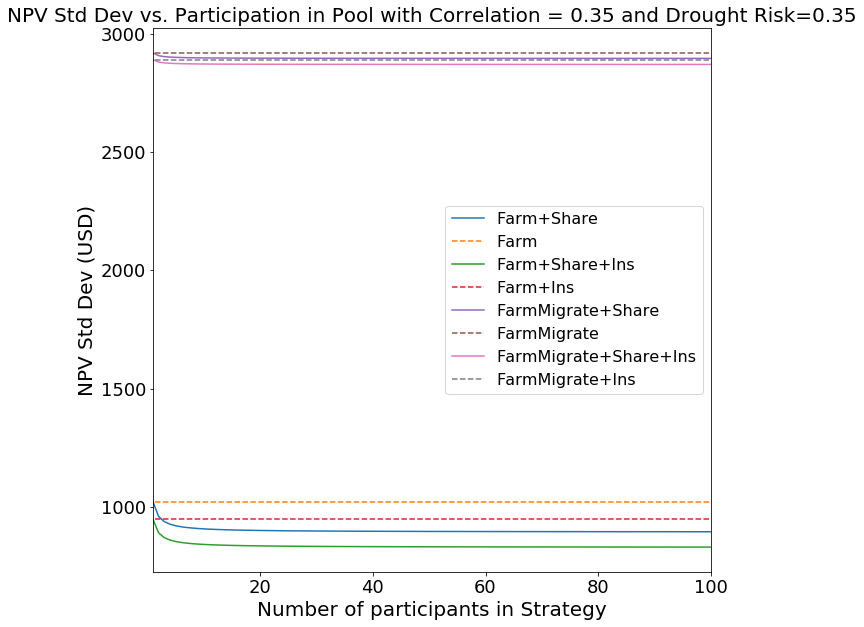

In [74]:
#Plotting variance of shared pool as a function of participants (varying strategies)

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
    
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']

x = np.linspace(0,households, households+1)

y = np.zeros(households+1)
y_0 = np.zeros(households+1)
#frequency_dist = {key: 0 for key in strategy_names}
#strategy='FarmMigrate+Share'
#baseline = 'FarmMigrate'

shared_strategies = ['Farm+Share', 'Farm+Share+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
baseline_strategies = ['Farm', 'Farm+Ins', 'FarmMigrate', 'FarmMigrate+Ins']

y_var = {key : y for key in shared_strategies}
y0_var = {key: y_0 for key in baseline_strategies}


f, ax1 = plt.subplots(figsize=[10,10])

for strat, base in zip(shared_strategies, baseline_strategies):
    frequency_dist = {key: 0 for key in strategy_names}
    for i in range(len(x)):
        frequency_dist[strat] = x[i] / households
        stdevs = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, p_cov, strategy_names, time_horizon, discount_rate)

        y_var[strat][i] = npv_calc(stdevs[strat], time_horizon, discount_rate) 
        y0_var[base][i] = npv_calc(stdevs[base], time_horizon, discount_rate)
    

    ax1.plot(x,y_var[strat], label=strat)
    ax1.plot(x,y0_var[base], ls='--', label=base)
    
#ax1.plot(x, y_0, ls='--')
ax1.set_ylabel('NPV Std Dev (USD)', size=20)
ax1.set_xlabel('Number of participants in Strategy', size=20)
ax1.set_xlim([1,households])
#ax1.set_ylim([-500, -750])
#ax1.set_xlim([1,5])
plt.legend(fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('NPV Std Dev vs. Participation in Pool with Correlation = ' + str(p_cov) + ' and Drought Risk=' + str(p_drought), size=20)
plt.show()

#plt.savefig('PoolVariance_Drought0.2Corr0.1.png', bbox_inches='tight')
    

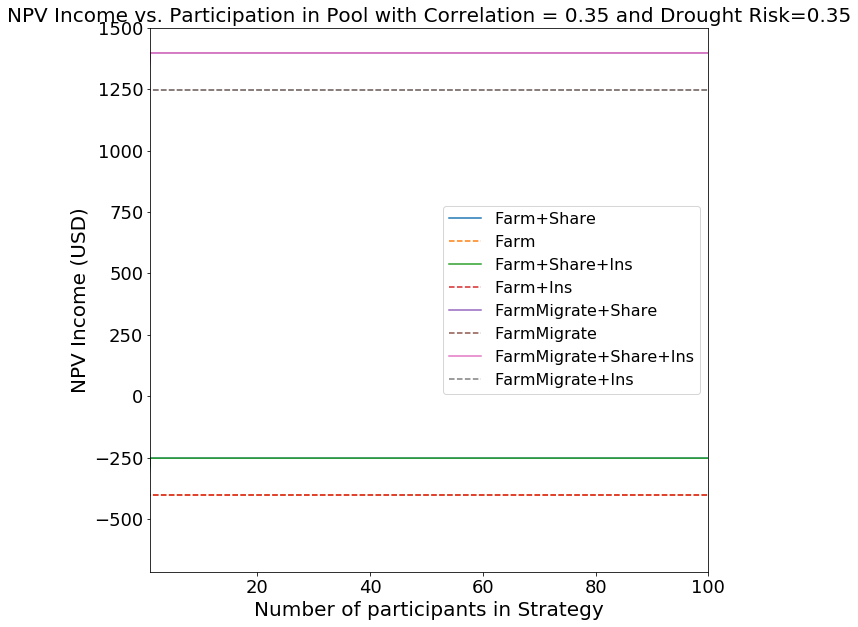

In [75]:
#Plotting Income of shared pool as a function of participants (varying strategies)

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']

x = np.linspace(0,households, households+1)

y = np.zeros(households+1)
y_0 = np.zeros(households+1)


shared_strategies = ['Farm+Share', 'Farm+Share+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
baseline_strategies = ['Farm', 'Farm+Ins', 'FarmMigrate', 'FarmMigrate+Ins']

y_inc = {key : y for key in shared_strategies}
y0_inc = {key: y_0 for key in baseline_strategies}


f, ax1 = plt.subplots(figsize=[10,10])

for strat, base in zip(shared_strategies, baseline_strategies):
    frequency_dist = {key: 0 for key in strategy_names}
    for i in range(len(x)):
        frequency_dist[strat] = x[i] / households
        incomes = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)

        y_inc[strat][i] = npv_calc(incomes[strat], time_horizon, discount_rate)
        y0_inc[base][i] = npv_calc(incomes[base], time_horizon, discount_rate)
    

    ax1.plot(x,y_inc[strat], label=strat)
    ax1.plot(x,y0_inc[base], ls='--', label=base)
    
#ax1.plot(x, y_0, ls='--')
ax1.set_ylabel('NPV Income (USD)', size=20)
ax1.set_xlabel('Number of participants in Strategy', size=20)
ax1.set_xlim([1,households])
#ax1.set_ylim([-500, -750])
plt.legend(fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('NPV Income vs. Participation in Pool with Correlation = ' + str(p_cov) + ' and Drought Risk=' + str(p_drought), size=20)
plt.show()

#plt.savefig('PoolIncome_Drought0.2Corr0.1.png', bbox_inches='tight')

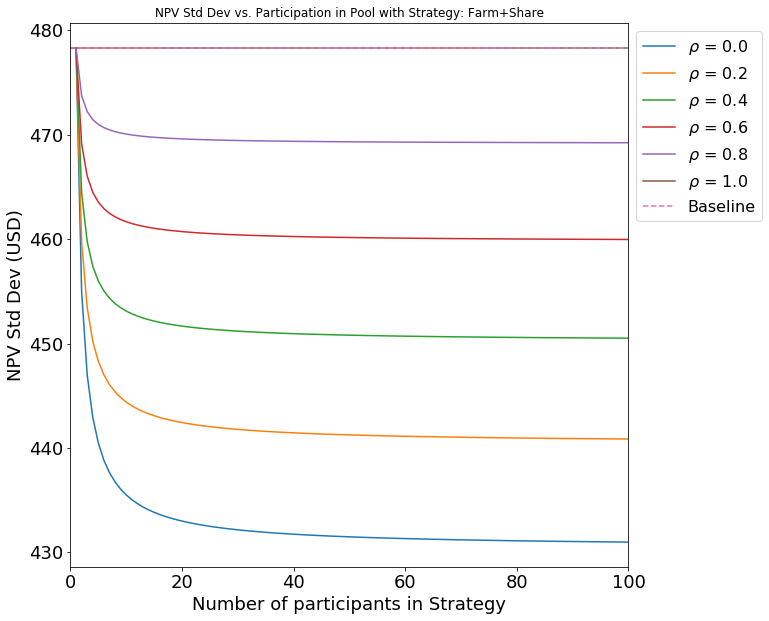

In [15]:
#Plotting variance of shared pool as a function of correlation between incomes

x = np.linspace(0,households, households+1)

y = np.zeros(households+1)
y_0 = np.zeros(households+1)
strategy='Farm+Share'
baseline = 'Farm'


rho = np.linspace(0, 1, 6)
keys = []
for i in range(len(rho)):
    keys.append(str(rho[i]))

y_dict = {key : y for key in keys}
y0_dict = {key: y_0 for key in keys}


f, ax1 = plt.subplots(figsize=[10,10])

for j, value in enumerate(keys):

    frequency_dist = {key: 0 for key in strategy_names}
    for i in range(len(x)):
        frequency_dist[strategy] = x[i] / households
        stdevs = variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, rho[j], strategy_names, time_horizon, discount_rate)
        y_dict[value][i] = npv_calc(stdevs[strategy], time_horizon, discount_rate)
        y0_dict[value][i] = npv_calc(stdevs[baseline], time_horizon, discount_rate)
    

    ax1.plot(x,y_dict[value], label= r'$\rho$ = ' + value[0:3])
ax1.plot(x,y0_dict[value], ls='--', label='Baseline')
#ax1.plot(x, y_0, ls='--')
ax1.set_ylabel('NPV Std Dev (USD)', size=18)
ax1.set_xlabel('Number of participants in Strategy', size=18)
ax1.set_xlim([0,100])
#ax1.set_ylim([120, 150])
plt.legend(fontsize=16, bbox_to_anchor = (1,1), loc='upper left')
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('NPV Std Dev vs. Participation in Pool with Strategy: ' + str(strategy))
plt.show()

#plt.savefig('PoolVariance_FarmShare_Beta0.1.png', bbox_inches='tight')
    


In [ ]:
#Variance as a function of drought risk

p_drought = np.linspace(0.1,0.9,9)
rho = [0.1, 0.35, 0.6]
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
target_strategies = ['FarmMigrate', 'FarmMigrate+Ins']

for r in rho:
    target_strategies.append('FarmMigrate+Share_' + str(r))
    
colors = {key: 'red' for key in target_strategies}
colors['FarmMigrate'] = 'gray'
colors['FarmMigrate+Ins'] = 'black'

lines = {key: 'solid' for key in target_strategies}
lines['FarmMigrate+Share_0.35'] = 'dashed'
lines['FarmMigrate+Share_0.6'] = 'dotted'

frequency_dist = {key: 0 for key in strategy_names}
std_array = {key: [] for key in target_strategies}
income_array = {key: [] for key in target_strategies}

frequency_dist['FarmMigrate+Share'] = 0.1
frequency_dist['FarmMigrate'] = 1 - frequency_dist['FarmMigrate+Share']

for p in p_drought:
    print(p)
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p, objective_drought, max_farm)
    mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p, max_farm)
    stdevs = variance_calc(mu_farm, farm_k, p, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, rho[0], strategy_names, time_horizon, discount_rate)
    incomes = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p, subsidy, matching, time_horizon, discount_rate)

    for item in target_strategies:
        if 'Share' not in item:
            std_array[item].append(npv_calc(stdevs[item], time_horizon, discount_rate))
            income_array[item].append(npv_calc(incomes[item], time_horizon, discount_rate))
            
    for i in range(len(rho)):
        share_std = variance_calc(mu_farm, farm_k, p, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, frequency_dist, households, rho[i], strategy_names, time_horizon, discount_rate)['FarmMigrate+Share']        
        share_income = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p, subsidy, matching, time_horizon, discount_rate)['FarmMigrate+Share']
        std_array['FarmMigrate+Share_' + str(rho[i])].append(npv_calc(share_std, time_horizon, discount_rate))
        income_array['FarmMigrate+Share_' + str(rho[i])].append(npv_calc(share_income, time_horizon, discount_rate))

f, ax1 = plt.subplots(figsize=[10,10])

for item in target_strategies:
    ax1.plot(p_drought, std_array[item], label=item, color=colors[item], ls=lines[item])

ax1.set_xlabel('Drought Risk', fontsize=20)
ax1.set_ylabel('Standard Deviation (USD)', fontsize=20)

plt.legend(fontsize=16, loc='upper right')
plt.xticks(size=18)
plt.yticks(size=18)

#plt.show()

plt.savefig('Variance_DroughtRisk.png', bbox_inches='tight')




0.1


In [28]:
#Plot of expected income as a function of drought risk

f, ax1 = plt.subplots(figsize=[10,10])

ax1.plot(p_drought, income_array['FarmMigrate'], label='FarmMigrate', color=colors['FarmMigrate'], ls='solid')
ax1.plot(p_drought, income_array['FarmMigrate+Ins'], label='FarmMigrate+Ins', color=colors['FarmMigrate+Ins'], ls='dashed')
ax1.plot(p_drought, income_array['FarmMigrate+Share_0.1'], label='FarmMigrate+Share', color=colors['FarmMigrate+Share_0.1'], ls='dotted')


ax1.set_xlabel('Drought Risk', fontsize=20)
ax1.set_ylabel('Expected Income (USD/cycle)', fontsize=20)

plt.legend(fontsize=16, loc='upper right')
plt.xticks(size=18)
plt.yticks(size=18)

#plt.show()

plt.savefig('ExpectedIncome_DroughtRisk.png', bbox_inches='tight')

## Strategy Utilities as a Function of Strategy Distribution

In [67]:
#Pairwise Invasability Plot featuring two strategies
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
strategy_x = 'FarmMigrate+Share'
strategy_y = 'FarmMigrate+Ins'
strategy_z = 'FarmMigrate+Share+Ins'

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)
    

steps = 21

x = np.linspace(0,1,steps)
y = np.linspace(0,1,steps)

max_value = []

for i in range(steps):
    
    max_col = []
    
    for j in range(steps):

        if (x[i] + y[j]) <= 1:
            utilities = {key : 0 for key in strategy_names} 
            
            for strategy in strategy_names:
                frequency = []
                distribution = {key : 0 for key in strategy_names}
                distribution[strategy_x] = x[i]
                distribution[strategy_y] = y[j]
                distribution[strategy_z] = 1 - distribution[strategy_x] - distribution[strategy_y]
                frequency.append(distribution)
                utilities[strategy] = utility_select(utility_function, strategy_names, risk_factor, frequency, strategy_x, strategy, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)[1]
            max_col.append(max(zip(utilities.values(), utilities.keys()))[1])
            
        else:
            max_col.append('')
            
    
    max_value.append(max_col)

    



In [69]:
#Plot
X, Y = np.meshgrid(x, y)

strategy_dict = {'Farm': 0, 'Farm+Share': 1, 'Farm+Ins': 2, 'Farm+Share+Ins': 3, 'FarmMigrate': 4, 'FarmMigrate+Share': 5, 'FarmMigrate+Ins': 6, 'FarmMigrate+Share+Ins': 7, '': 8}
color_dict = {'Farm': 'blue', 'Farm+Share': 'green', 'Farm+Ins': 'purple', 'Farm+Share+Ins': 'pink', 'FarmMigrate': 'orange', 'FarmMigrate+Share': 'red', 'FarmMigrate+Ins': 'brown', 'FarmMigrate+Share+Ins': 'gray', '': 'white'}
z = np.zeros((steps, steps))
for a in range(steps):
    for b in range(steps):
        z[a,b] = strategy_dict[max_value[a][b]]
        
level_labels=[]
bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        
f, ax = plt.subplots(figsize=[15,10])
cmap = (mpl.colors.ListedColormap(color_dict.values()))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)   

c = plt.pcolormesh(X, Y, z, shading='flat', cmap=cmap, norm=norm)


#Customizing colorbar
cbar = plt.colorbar(ticks= [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])

cbar.ax.set_yticklabels(['Farm', 'Farm+Share', 'Farm+Ins', 'Farm+Share+Ins', 'FarmMigrate', 'FarmMigrate+Share', 'FarmMigrate+Ins', 'FarmMigrate+Share+Ins'], rotation=0)

#ax.set_xlabel(str(strategy_x), size=20)

ax.set_ylim([-0.05,1.05])
ax.set_xlim([-0.05,1.05])
#ax.set_ylabel(str(strategy_y), size=20)

plt.text(-0.1, -0.05, str(strategy_z), size=20)
plt.text(1.0, -0.05, str(strategy_x), size=20)
plt.text(0.0, 1.0, str(strategy_y), size=20)
plt.xticks(size=18)
plt.yticks(size=18)
#plt.show()

plt.savefig(str(utility_function) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov) + '_alpha1_3WayPip.png', bbox_inches='tight')


# Simulation Plots

## Single Simulation Plot

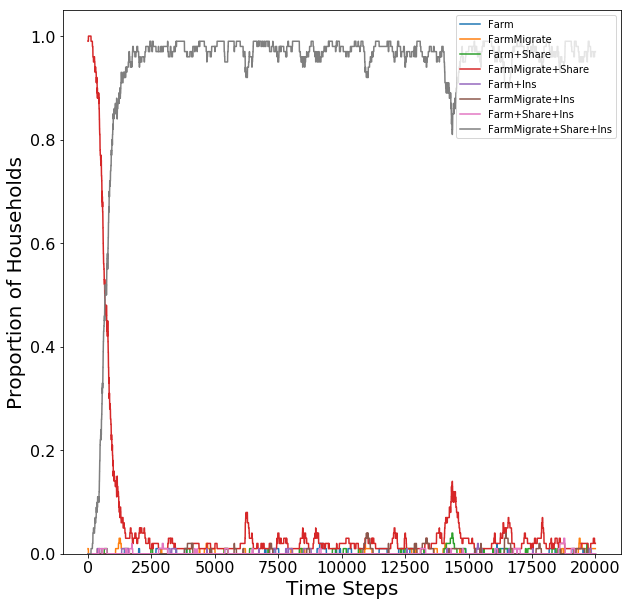

In [23]:
#Plot of strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}
max_value = np.zeros(time)

for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros(time)


for t in range(time):
    for var_name, item in zip(local_variables.keys(), strategy_names):      
        local_variables[var_name][t] = sim_frequency_dist[0][t][item]
    max_value[t] = max(sim_frequency_dist[0][t].values())
    
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in local_variables.items():
    ax1.plot(x, value, label=key)
    
#ax1.plot(x, max_value + 0.01, linestyle='--', color='dodgerblue', label='Max Value')
plt.legend(loc = 'upper right')
ax1.set_ylim([0,1.05])
#ax1.set_xlim([0, 10])
ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('ExampleSelf-Interested.eps', bbox_inches='tight')


## Average of Multiple Simulations over Time

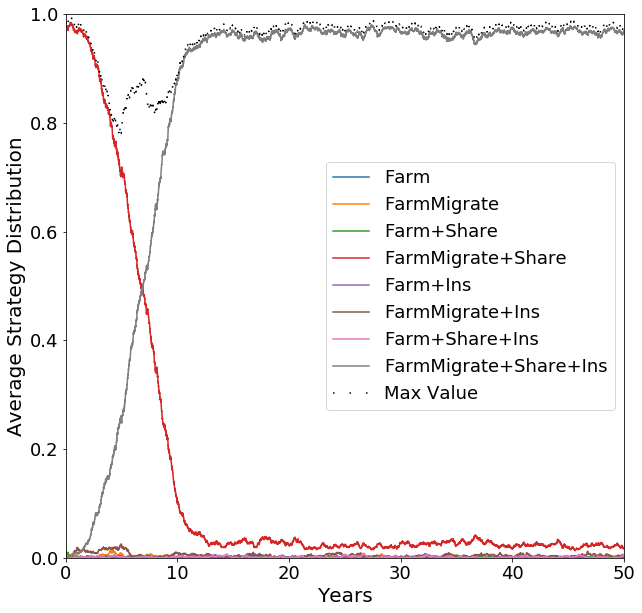

In [27]:
#Plot of average strategy distribution over time (averaged across simulations)

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
#simulation_run = np.load('Self-Interested_Drought0.5_Corr0.6_FarmIncomes_frequencydist.npy', allow_pickle = True)
simulation_run = sim_frequency_dist
max_value = np.zeros((simulations, time))
avg_max_value = np.zeros(time)

local_variables = {key: [] for key in strategy_names}

avg_sim_time_distribution = {key: [] for key in strategy_names}

for var_name in strategy_names:
    
    local_variables[var_name] = np.zeros((simulations, time))
    for a in range(simulations):
        for t in range(time):
            local_variables[var_name][a,t] = simulation_run[a][t][var_name]
    
    avg_time_distribution = np.zeros(time)
    for t in range(time):
        avg_time_distribution[t] = np.average(local_variables[var_name][:,t])
    
    avg_sim_time_distribution[var_name] = avg_time_distribution

for t in range(time):
    for a in range(simulations):
        max_value[a][t] = max(simulation_run[a][t].values())

    avg_max_value[t] = np.average(max_value[:,t])
    
f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0, time, time)
x_adj = x / (households*annual_decisions)

labels = []

for key in strategy_names:
    if beta == 0:
        if 'Share' in key:
            equivalent = key.replace('+Share', '')
            labels.append('_')
            avg_sim_time_distribution[equivalent] += avg_sim_time_distribution[key]
            avg_sim_time_distribution[key] = np.zeros(time)
        else:
            labels.append(key)
            
    else:
        labels = strategy_names

for key, label in zip(strategy_names, labels):
    y = np.asarray(avg_sim_time_distribution[key])
    ax.plot(x_adj, y, label = str(label))
    

            
ax.plot(x_adj, avg_max_value+0.01, ls= (0, (1,10)), color='black', label='Max Value')
ax.set_ylim([0,1])
ax.set_xlim([0,50])
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Average Strategy Distribution', fontsize=20)

plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=18)
plt.show()

#plt.savefig('Self-Interested_Drought0.35_Corr0.35_FarmIncomes_strategies.png', bbox_inches='tight')


## Final Income Distribution

In [ ]:
#Generating income distribution of community based on final strategy choices

#Loading previous data
simulations = 100
households = 100
p_drought = 0.8

sim_strategies = []
frequency_dist = np.load('Risk-Seeking_Communitarian_frequencydist.npy', allow_pickle=True)
for a in range(simulations):
    strategies = []
    for item in strategy_names:
        number = round(frequency_dist[a][-1][item] * households)
        for i in range(number):
            strategies.append(item)

    sim_strategies.append(strategies)

final_choices = {key: 0 for key in strategy_names} #Dictionary tracking # households for each strategy at terminal time

farm_k_d = wei_shape(mu_farm_drought, math.sqrt(uninsured_var))
farm_k_nd = wei_shape(mu_farm_nd, math.sqrt(insured_var))

farm_drought_scale = wei_scale(mu_farm_drought, farm_k_d)
farm_nd_scale = wei_scale(mu_farm_nd, farm_k_nd)

rem_mu, rem_sigma = lognorm_factors(mu_migrate, math.sqrt(var_migrate))

share_contribution = np.zeros((simulations, households))
household_incomes = np.zeros((simulations, households))


for a in range(simulations):    
    for i in range(households):
        p = np.random.random()
        if p < p_drought:
            farm_draw = farm_drought_scale * np.random.weibull(farm_k_d, 1)
        else:
            farm_draw = farm_nd_scale * np.random.weibull(farm_k_nd, 1)
            
        rem_draw = 0
        migrate_adjust = 1
        premium = 0
        if 'Migrate' in sim_strategies[a][i]:
            rem_draw = np.random.lognormal(rem_mu, rem_sigma, size=1)
            migrate_adjust = eta

        if 'Ins' in sim_strategies[a][i]:
            farm_draw = mu_farm_nd * np.random.weibull(farm_k_nd, 1)
            premium = p_drought * migrate_adjust * (mu_farm_nd - mu_farm_drought)
            
        household_incomes[a,i] = farm_draw * migrate_adjust + rem_draw - premium
        
        if 'Share' in sim_strategies[a][i]:
            share_contribution[a,i] = beta * household_incomes[a,i]
            household_incomes[a,i] -= share_contribution[a,i]
        
    #Adjusting incomes for shared pool
    pooled_incomes = share_contribution[a,:][share_contribution[a,:] != 0]
    if len(pooled_incomes) == 0:
        pool_contribution = 0
    else:
        pool_contribution = np.average(pooled_incomes)

    for j in range(households):
        if 'Share' in sim_strategies[a][j]:
            household_incomes[a,j] += pool_contribution

        

In [ ]:
#Plotting distribution as a histogram

income_distribution = [income for sim in household_incomes for income in sim]
mean_income = np.average(income_distribution)
poverty_threshold = 100

simulation_mean = np.zeros(simulations)
simulation_std = np.zeros(simulations)
poverty_rate = np.zeros(simulations)

for a in range(simulations):
    simulation_mean[a] = np.average(household_incomes[a,:])
    simulation_std[a] = np.std(household_incomes[a,:])
    poverty_rate[a] = np.count_nonzero(household_incomes[a,:] < poverty_threshold) / households

cross_std = np.std(simulation_mean)
avg_std = np.average(simulation_std)
avg_poverty = np.average(poverty_rate)

print('Avg Income:', mean_income)
print('Uncertainty:', cross_std)
print('Inequality:', avg_std)
print('Poverty Rate:', avg_poverty)

n_bins = 200

fig, axs = plt.subplots(1, 1, figsize=(10,10))

axs.hist(income_distribution, n_bins)
axs.set_xlim([0,4000])
plt.axvline(mean_income, color='black', ls='--', label='Mean Income')
plt.axvline(cross_std, color ='red', ls ='--', label='Std Dev of Simulation Mean Income (Uncertainty)')
plt.axvline(avg_std, color='green', ls='--', label='Average of Simulation Std Dev (Inequality)')
plt.xlabel('Household Income (USD/cycle)', fontsize=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=16)
plt.show()

#plt.savefig('Risk-Seeking_Communitarian_fixedstrategies_income.png', bbox_inches='tight')

## Single-Parameter Sensitivity

In [45]:
#Create arrays for proportion of households in any strategy over time
parameter_array = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']


sens_frequency_dist = {}
avg_proportion = {key: [] for key in strategy_names}
std_proportion = {key: [] for key in strategy_names}

avg_final_proportion = {key: [] for key in strategy_names}
std_final_proportion = {key: [] for key in strategy_names}


for value in parameter_array:
    key = str(value)
    sens_frequency_dist[key] = np.load('Self-Interested_BetaSens' + '_frequencydist.npy', allow_pickle=True)
    local_variables = {}
    avg_sim_proportion = {}
    final_sim_proportion = {}
    avg_time_proportion = {}

    for item in strategy_names:
        var_name = str(item)
        local_variables[var_name] = np.zeros((simulations,time))
        avg_sim_proportion[var_name] = np.zeros(simulations)
        final_sim_proportion[var_name] = np.zeros(simulations)
        avg_time_proportion[var_name] = np.zeros(time)

    for a in range(simulations):
        for t in range(time):
            for var_name, item in zip(local_variables.keys(), strategy_names):      
                local_variables[var_name][a,t] = sens_frequency_dist[value][-1][a][t][item]

    for var_name in local_variables.keys():
        
        for sim in range(simulations):
            avg_sim_proportion[var_name][sim] = np.average(local_variables[var_name][sim,:])
            final_sim_proportion[var_name][sim] = local_variables[var_name][sim,-1]
            
        avg_proportion[var_name].append(np.average(avg_sim_proportion[var_name]))
        avg_final_proportion[var_name].append(np.average(final_sim_proportion[var_name]))
        
        std_proportion[var_name].append(np.std(avg_sim_proportion[var_name]))
        std_final_proportion[var_name].append(np.std(final_sim_proportion[var_name]))


IndexError: index 5000 is out of bounds for axis 0 with size 5000

In [ ]:
#Line Plot of Avg Strategy Proportions as a function of parameter

f, ax = plt.subplots(figsize=[10,10])
x = np.linspace(0.0, 1.0, 6)
max_values = np.zeros((sensitivity_steps, simulations))
avg_max_values = np.zeros(sensitivity_steps)

for i in range(sensitivity_steps):
    for a in range(simulations):
        max_values[i,a] = max(sens_frequency_dist[i][a][-1])
    avg_max_values[i] = np.average(max_values[:,a])


for key in strategy_names:
    y = np.asarray(avg_proportion[key])
    err = np.asarray(std_proportion[key])
    ax.plot(x, y, label = str(key))
    #ax.fill_between(x, y - err, y + err)

    ax.set_ylim([0,1])
ax.set_xlabel('Moralis $k$ factor')
ax.set_ylabel('Avg Strategy Share')
plt.legend()
plt.show()

#plt.savefig('Altruistic_AltruismSens.png', bbox_inches='tight')

## Bar Graph of Final Strategy Proportions

In [15]:
#Bar Graph of average strategy distributions over simulations

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_time_proportion = {}
avg_proportion={}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])



f, ax = plt.subplots(figsize=[10,10])
x = np.arange(time)

categories = np.arange(1)
ax.bar(categories, avg_proportion['FarmMigrate'], label='FarmMigrate', color='orange')
ax.bar(categories, avg_proportion['FarmMigrate+Share'], bottom=avg_proportion['FarmMigrate'], label='FarmMigrate+Share', color='red')
ax.bar(categories, avg_proportion['FarmMigrate+Ins'], bottom=(avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Ins', color='sienna')
ax.bar(categories, avg_proportion['FarmMigrate+Share+Ins'], bottom=(avg_proportion['FarmMigrate+Ins'] + avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Share+Ins', color='black')

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()

#ax1.set_xlabel('Time Steps', size=20)
ax.set_ylabel('Proportion of Time Spent in Each Strategy', size=20)

plt.yticks(fontsize=16)
plt.show()

#np.save(avg_proportion, 'P0.3_proportion_10sim.npy')

#print(type(avg_proportion))
#data = json.dumps(avg_proportion)
#f = open("P0.01_proportion.json","w")
#f.write(data)
#f.close()

#plt.savefig('Altruism05_10sim.eps', bbox_inches='tight')

NameError: name 'strategy_names' is not defined

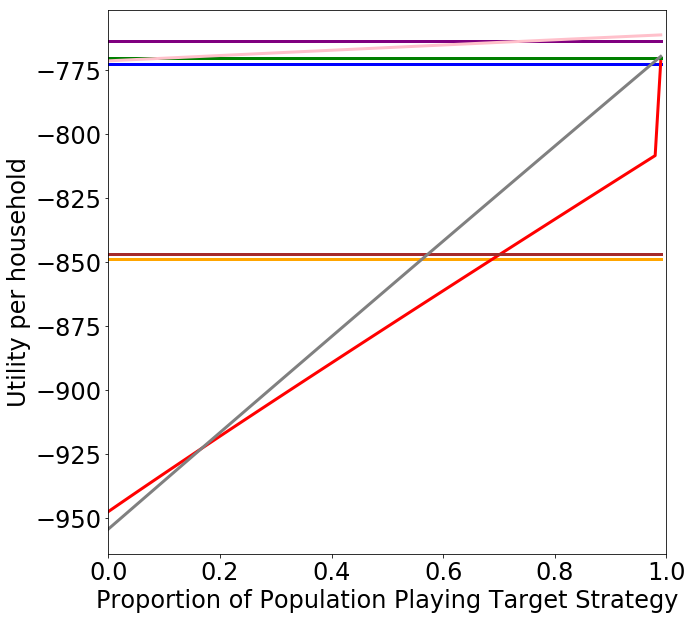

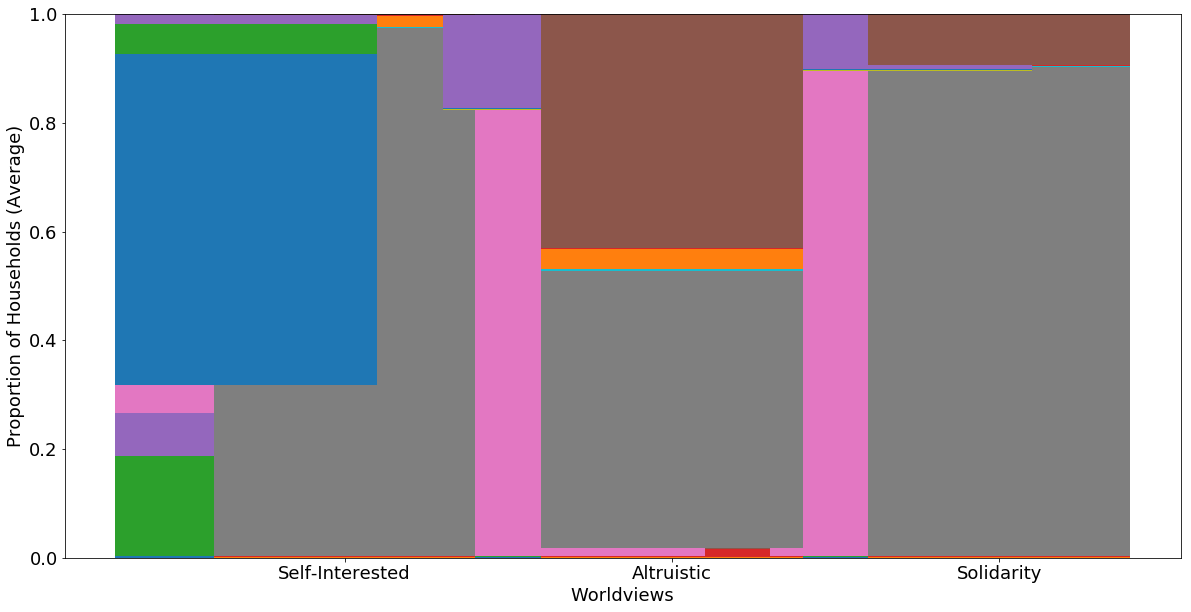

In [69]:
#Bar plot of multiple worldviews
strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
worldviews_intl = {'Self-Interested':{key:0 for key in strategy_names}, 'Altruistic':{key:0 for key in strategy_names}, 'Solidarity':{key:0 for key in strategy_names}}
worldviews_local = {'Self-Interested':{key:0 for key in strategy_names}, 'Altruistic':{key:0 for key in strategy_names}, 'Solidarity':{key:0 for key in strategy_names}}

self_interested = np.load('Self-Interested_frequencydist.npy', allow_pickle=True)
altruistic = np.load('Altruistic_frequencydist.npy', allow_pickle=True)
solidarity = np.load('Moralis_frequencydist.npy', allow_pickle=True)

local_self_interested = np.load('Self-Interested_localmigrate_frequencydist.npy', allow_pickle=True)
local_altruistic = np.load('Altruistic_localmigrate_frequencydist.npy', allow_pickle=True)
local_solidarity = np.load('Moralis_localmigrate_frequencydist.npy', allow_pickle=True)

barWidth = 0.3

data_intl = [self_interested, altruistic, solidarity]
data_local = [local_self_interested, local_altruistic, local_solidarity]
fig, ax = plt.subplots(figsize=[20,10])
xpos_intl = np.arange(len(data_intl))
xpos_local = [x + barWidth for x in xpos_intl]

#Loop through this next part

for i, view in enumerate(worldviews_intl):
    final_distributions_intl = {key : [] for key in strategy_names}
    final_distributions_local = {key : [] for key in strategy_names}

    for item in strategy_names:
        for a in range(simulations):
            final_distributions_intl[item].append(data_intl[i][a][-1][item])
            final_distributions_local[item].append(data_local[i][a][-1][item])

        worldviews_intl[view][item] = np.average(final_distributions_intl[item])         
        worldviews_local[view][item] = np.average(final_distributions_local[item])         

y_intl = np.zeros((len(strategy_names), len(worldviews_intl)))
y_local = np.zeros((len(strategy_names), len(worldviews_local)))

for j, strategy in enumerate(strategy_names):
    for i, view in enumerate(worldviews_intl):
        y_intl[j][i] = worldviews_intl[view][strategy]
        y_local[j][i] = worldviews_local[view][strategy]
        
running_bottom_intl = np.zeros(len(worldviews_intl))
running_bottom_local = np.zeros(len(worldviews_intl))

for i, strategy in enumerate(strategy_names):
    ax.bar(sorted(xpos_intl), y_intl[i], bottom = running_bottom_intl, align='center', label=str(strategy))
    running_bottom_intl += y_intl[i]
    ax.bar(sorted(xpos_local), y_local[i], bottom = running_bottom_local, align='center', label=str(strategy))
    running_bottom_local += y_local[i]    

#ax.set_xticklabels(['Self-Interested', 'Altruistic', 'Solidarity'])
ax.set_ylim([0,1])
ax.set_ylabel('Proportion of Households (Average)', size=18)
ax.set_xlabel('Worldviews', size=18)
plt.xticks([r + barWidth for r in range(len(xpos_intl))], ['Self-Interested', 'Altruistic', 'Solidarity'], fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=16)
plt.show()

#plt.savefig('Worldviewcomparison_local.png', bbox_inches='tight')

# Transition Matrix Calculations

In [ ]:
#strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
strategy_names = ['Farm', 'Farm+Ins', 'Farm+Share', 'Farm+Share+Ins', 'FarmMigrate', 'FarmMigrate+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought(mu_farm, farm_k, p_drought, objective_drought)
matrix = transition_matrix(strategy_names, households, utility_function, risk_factor, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, uninsured_var, insured_var, var_migrate, beta, cost_farm, cost_migrate, p_drought, altruism_factor, max_altruism, k, mutation_rate)
print(matrix)

#transpose_matrix = np.transpose(matrix)

In [ ]:
from scipy.linalg import eig
from array import array

a = []
for key in matrix:
    row = []
    for item in matrix[key]:
        row.append(matrix[key][item])
    a.append(row)
    
probability_matrix = np.array(a)
print('Matrix:', probability_matrix)

transpose_matrix = [[probability_matrix[j][i] for j in range(len(trans_matrix))] for i in range(len(trans_matrix[0]))]
print('Transpose:', transpose_matrix)

A=np.append(np.transpose(probability_matrix)-np.identity(8),[[1,1,1,1,1,1,1,1]],axis=0) 
b=np.transpose(np.array([0,0,0,0,0,0,0,0,1]))
eigen = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

total = np.sum(eigen)
stationary_dist = []
for value in eigen:
    stationary_dist.append(np.abs(value)/ total)
    
stationary_dist

#w,v = scipy.linalg.eig(probability_matrix, left=True, right=False)

#print('E-value:', w)
#print('E-vector', v)
#idx = np.argmin(np.abs(w - 1))
#vec = np.real(v[idx])

#print('Stationary Distribution:', vec/np.sum(vec))

#for value, vector in zip(w,v):
    #if value == 1:
    #if np.min(vector) > -0.01:
        #stationary_dist = []
        #total = np.sum(np.abs(vector))
        #for value in vector:
            #stationary_dist.append(np.abs(value) / total)
        #print('Possible distribution:', stationary_dist)

# Calculate Utilities as a Function of Strategy Share

In [32]:
#Calculate income distribution properties

adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p_drought, max_farm)

#Calculate utility of strategy x as a function of share of population playing strategy

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
x = np.arange(0,households,1)

#target_strategy = ['Farm+Share', 'FarmMigrate+Ins', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins']
target_strategy = ['Farm', 'Farm+Share', 'Farm+Ins', 'Farm+Share+Ins', 'FarmMigrate', 'FarmMigrate+Share', 'FarmMigrate+Share+Ins', 'FarmMigrate+Ins', ]


color_dict = {'Farm': 'blue', 'Farm+Share': 'green', 'Farm+Ins': 'purple', 'Farm+Share+Ins': 'pink', 'FarmMigrate': 'orange', 'FarmMigrate+Share': 'red', 'FarmMigrate+Ins': 'brown', 'FarmMigrate+Share+Ins': 'gray'}

y = {key: np.zeros(len(x)) for key in target_strategy}


alternate_strategy = 'FarmMigrate+Share+Ins'


for strategy in target_strategy:
    for i in range(households):
        distribution = []
        frequency = {key: 0 for key in strategy_names}
       
        if strategy == alternate_strategy:
            frequency[strategy] = households / households
        else:
            frequency[strategy] = i / households
            frequency[alternate_strategy] = (households - i) / households
        
        distribution.append(frequency)
        
        utility = utility_select(utility_function, strategy_names, risk_factor, distribution, alternate_strategy, strategy, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)

        y[strategy][i] = utility[1]
        

#sorted_strat = np.sort(y['FarmMigrate+Share+Ins'])
#crossover = np.argwhere(y['FarmMigrate+Share+Ins'] > y['FarmMigrate+Share'][0])[0] / households
#print(crossover)
        

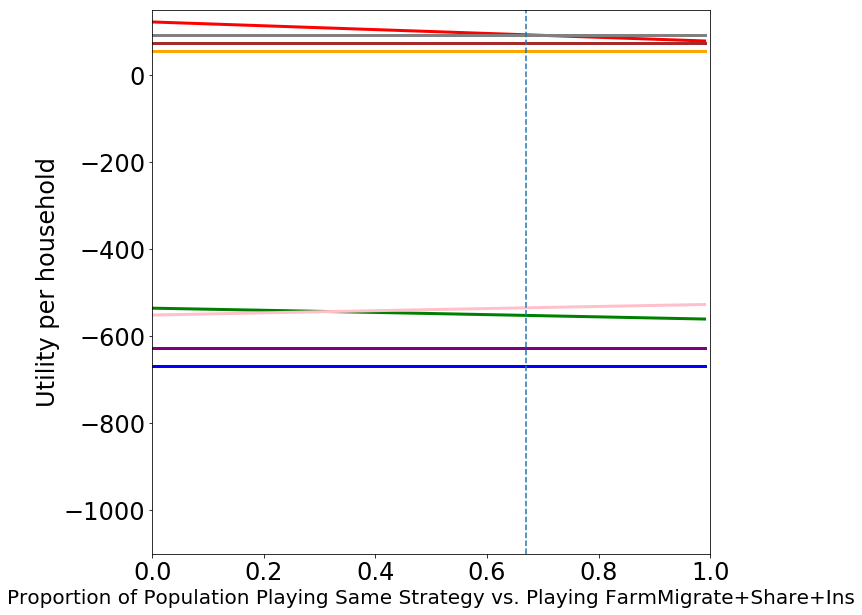

In [34]:
#Plot results

f, ax1 = plt.subplots(figsize=[10,10])

for key in color_dict:
    ax1.plot(x / households, y[key], label=str(key), color=color_dict[key], lw=3)

ax1.set_xlabel('Proportion of Population Playing Same Strategy vs. Playing ' + str(alternate_strategy), size=20)
#ax1.set_xlabel('Proportion of Population Playing Target Strategy', size=24)

ax1.set_ylabel('Utility per household', size = 24)
ax1.set_xlim([0,1.0])

ax1.set_ylim([-1100,150])
#plt.legend(fontsize=18)
plt.axvline(crossover, ls = '--', label='Coordination Point')
#plt.legend(fontsize=18, loc='center right')
plt.xticks(np.arange(0, 1.05, 0.2), fontsize=24)
plt.yticks(fontsize=24)


plt.show()

#prefix = str(utility_function) + '_Drought' + str(p_drought) + '_Corr' + str(p_cov) + '_Beta' + str(beta)
#plt.savefig(str(prefix) + '_Utilities.png', bbox_inches='tight')

# Monomorphic State Utilities as a Function of Worldviews

In [ ]:
#Worldview Parameters
utility_function = 'Moralis'
migration_type = 'International'
risk_factor = 0.5
beta = 0.25
discount_rate = 0.05
p_cov = 0.6

if migration_type == 'International':
    mu_migrate = 594.8
    var_migrate = 998.2 ** 2
    cost_migrate = 500
    
elif migration_type == 'Local':
    mu_migrate = 200 
    var_migrate = 190 ** 2 
    cost_migrate = 62.5

else: 
    raise ValueError ('Migration type improperly specified')

In [ ]:
#Calculating utilities of each monomorphic strategy type

strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']
npv_incomes = {key: 0 for key in strategy_names}
npv_std = {key: 0 for key in strategy_names}
utilities = {key: 0 for key in strategy_names}
prior_distribution = []

for item in strategy_names:
    distribution = {key: 0 for key in strategy_names}
    distribution[item] = 1.0
    prior_distribution.append(distribution)
    prior_distribution.append(distribution)
    income = income_calc(strategy_names, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, beta, distribution, cost_farm, cost_migrate, p_drought, subsidy, matching, time_horizon, discount_rate)[item]
    npv_incomes[item] = npv_calc(income, time_horizon, discount_rate)
    
    std= variance_calc(mu_farm, farm_k, p_drought, eta, uninsured_var, insured_var, var_migrate, beta, rho_mig, distribution, households, p_cov, strategy_names, time_horizon, discount_rate)[item]
    npv_std[item] = npv_calc(std, time_horizon, discount_rate)

    utilities[item] = utility_select(utility_function, strategy_names, risk_factor, prior_distribution, item, item, households, mu_farm, mu_farm_drought, mu_farm_nd, farm_k, eta, mu_migrate, subsidy, matching, uninsured_var, insured_var, var_migrate, p_cov, rho_mig, beta, cost_farm, cost_migrate, p_drought, time_horizon, discount_rate, altruism_factor, max_altruism, k)[0]

#strategy_labels = ['Farm', 'FarmMigrate', '', 'Farm+Share', '', 'FarmMigrate+Share', '', 'Farm+Ins', '', 'FarmMigrate+Ins', '', 'Farm+Share+Ins', '', 'FarmMigrate+Share+Ins']

print(utilities)

plt.bar(utilities.keys(), utilities.values())
plt.xticks(rotation=90)
ax = plt.gca()
#ax.set_xticklabels(labels=npv_incomes.keys(),rotation=90)
ax.set_ylabel('NPV Utility ($)')
plt.show()

#plt.savefig('MonomorphicUtilities_FutureMindedCollaborator_fixedstrategies.png', bbox_inches='tight')


# Plot Fermi Probabilities as a Function of Relative Utility Difference

In [14]:
#Calculate transition probability of switching from strategy x to y as a function of relative utility differences

def fermi_prob(rel_utility_gap, sel_strength):
        
    #Probability will be lower value (closer to 0) when selection strength and utility difference is high
    try:
        transition_probability = (1 + math.exp(sel_strength * (-rel_utility_gap))) ** (-1)
    except OverflowError:
        transition_probability = 0
    
    return transition_probability

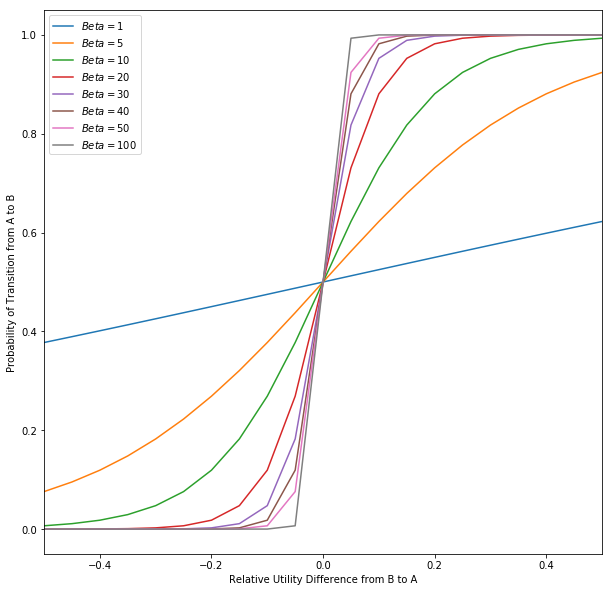

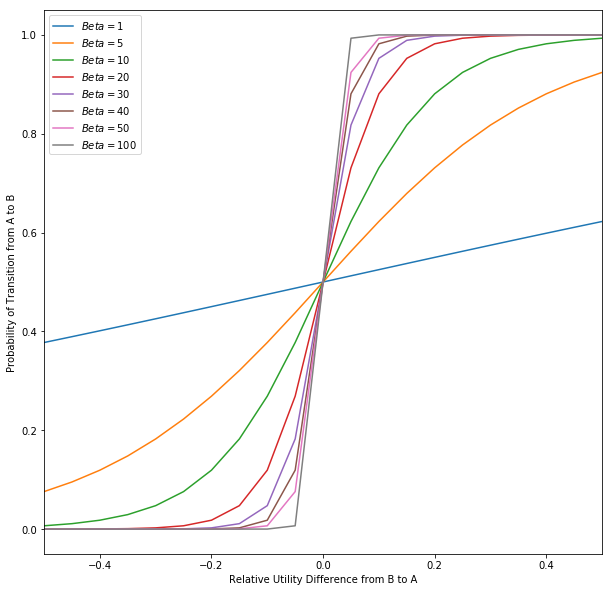

In [27]:
#Generate Plot of probability vs. utility gap
sel_strength = [1, 5, 10, 20, 30, 40, 50, 100]
utility_gaps = np.linspace(-1, 1, 41)
trans_prob = np.zeros((len(sel_strength), len(utility_gaps)))

for j, value in enumerate(sel_strength):
    for i in range(len(utility_gaps)):
        trans_prob[j, i] = fermi_prob(utility_gaps[i], value)


f, ax1 = plt.subplots(figsize=[10,10])

for k, item in enumerate(sel_strength):
    ax1.plot(utility_gaps, trans_prob[k], label = '$Beta = $' + str(item))
    
ax1.set_xlabel('Relative Utility Difference from B to A')
ax1.set_ylabel('Probability of Transition from A to B')
ax1.set_xlim([-0.5, 0.5])

plt.legend()
plt.show()

#plt.savefig('Logisticfunction_Betasens.png', bbox_inches='tight')

In [ ]:
#Plot of average strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_proportion = {}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])
    
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in avg_proportion.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()
ax1.set_ylim([0,1])
ax1.set_xlim([0, time])

ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('Altruism05.eps', bbox_inches='tight')


In [ ]:
# Create Bar plot with separate bars for each drought probability tested

probabilities = [0.01, 0.05, 0.1, 0.3]
local_variables = {}
means = {'FarmMigrate':[], 'FarmMigrate+Share':[], 'FarmMigrate+Ins':[], 'FarmMigrate+Share+Ins':[]}



for item in probabilities:
    
    f = open('P' + str(item) + '_proportion.json',)
    var_name = ('p_' + str(item))
    local_variables[var_name] = json.load(f)
    f.close()


categories = means.keys()

for strategy in categories:
    for key,value in local_variables.items():
        means[strategy].append(local_variables[key][strategy])

probability_order = list(local_variables.keys())

f, ax = plt.subplots(figsize=[10,10])

bottom_1 = means['FarmMigrate']
bottom_2 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] for i in range(len(means['FarmMigrate']))]
bottom_3 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] + means['FarmMigrate+Ins'][i] for i in range(len(means['FarmMigrate']))]

#[test_list1[i] + test_list2[i] for i in range(len(test_list1))]
ax.bar(probability_order, means['FarmMigrate'], label = 'FarmMigrate', color='dodgerblue')
ax.bar(probability_order, means['FarmMigrate+Share'], bottom = bottom_1, label = 'FarmMigrate+Share', color='green')
ax.bar(probability_order, means['FarmMigrate+Ins'], bottom = bottom_2, label = 'FarmMigrate+Ins', color='salmon')
ax.bar(probability_order, means['FarmMigrate+Share+Ins'], bottom = bottom_3, label = 'FarmMigrate+Share+Ins', color='darkorchid')

ax.set_xlabel('Drought Probability', size=18)
ax.set_ylabel('Proportion of Time', size=18)


plt.legend(fontsize=16)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


#plt.show()

plt.savefig('DroughtSensitivity.eps', bbox_inches='tight')

## Insurance Premiums as Function of Drought Risk

In [16]:
#Plot insurance premiums as a function of drought risks
mu_farm = 260.9 #For cereal crops only 176.5 #For all crops 260.93 #Previously mu_farm = 163.4
farm_k = 0.798 

drought_min = 0.1
drought_max = 1.0
p_drought = np.arange(drought_min, drought_max, 0.1)
premiums = np.zeros(len(p_drought))
avg_income = np.zeros(len(p_drought))
drought_threshold = np.zeros(len(p_drought))
variance = np.zeros(len(p_drought))


for i, p in enumerate(p_drought):
    print(i)
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p, objective_drought, max_farm)
    mu_farm_drought, mu_farm_nd, uninsured_var, insured_var = farm_drought_0(adj_k, adj_scale, p, max_farm)
    premiums[i] = p * eta * (mu_farm_nd - mu_farm_drought)
    avg_income[i] = mu_farm_nd
    drought_threshold[i] = mu_farm_drought
    variance[i] = uninsured_var

    
print(premiums)

f, ax1 = plt.subplots(figsize=[10,10])

ax1.plot(p_drought, premiums, label='Premiums')
ax1.plot(p_drought, avg_income, label = 'Avg Non-Drought Income')
ax1.plot(p_drought, drought_threshold, label = 'Drought Income', ls='--')

ax1.set_xlabel('Drought Probability', size=18)
ax1.set_ylabel('Insurance Premium (USD/cycle)', size=18)

#ax2 = ax1.twinx()
#ax2.plot(p_drought, variance, label='Variance', color='green')
plt.legend()
plt.show()

#plt.savefig('Premiums_Reshaped.png', bbox_inches='tight')

0
1
2
3
4
5
6
7
8
[ 27.88610193  43.85228506  55.45903598  63.83604623  78.96984506
  82.32039453  91.32151672 102.31024393 103.97274178]


#Plotting Weibull Distribution as a function of p_drought and shift
drought_values = [0.2, 0.5, 0.8]

variance = np.zeros(len(drought_values))
points = 1000000
n_bins = 1000
scale = (mu_farm / math.gamma(1 + 1 / farm_k))

income_distribution = scale * np.random.weibull(farm_k, size=100000)

sorted_income = list(np.sort(income_distribution))
drought_index = int(objective_drought * len(sorted_income)) - 1 
drought_threshold = sorted_income[drought_index]
f, axs = plt.subplots(2, 1, figsize=[10,10])

for i, p_drought in enumerate(drought_values):    
    #Shift drought threshold by tau to get p_drought density below drought threshold
    shift_index = int(p_drought * len(sorted_income)) - 1 #This establishes the two portions of distribution over which we will average, then shift
    shift_threshold = sorted_income[shift_index]
    tau = drought_threshold - shift_threshold
    shifted_income = list(np.sort(income_distribution + tau))
    adj_income = np.clip(shifted_income, 0, max_farm)
    mu_farm_test = np.average(adj_income)
    
    variance[i] = trunc_var(adj_income, mu_farm)
    
    
    axs[0].hist(adj_income, bins=n_bins, label='p =' + str(p_drought))
    
#axs[0].set_xlim([-750,750])
axs[0].set_ylim([0, 10000])
axs[0].set_xlabel('Income (USD/cycle)', fontsize=18)
axs[0].set_ylabel('Density', fontsize=18)
axs[0].axvline(drought_threshold, color='black')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
axs[0].legend(fontsize=18)

axs[1].plot(drought_values, variance)
plt.show()

#plt.savefig('ShiftedWeibullDistributions_trunc.png', bbox_inches='tight')



In [61]:
#Plotting Weibull Distribution as a function of p_drought and shift
drought_values = [0.2, 0.5, 0.8]
variance = np.zeros(len(drought_values))
adj_mu_farm = np.zeros(len(drought_values))
std_dev = np.zeros(len(drought_values))


n_bins=1000
f, axs = plt.subplots(2, 1, figsize=[10,10])
for i, p_drought in enumerate(drought_values): 
    mu_farm = 260.93 #Previously mu_farm = 163.4
    farm_k = 0.798 
    print('Drought Risk:', p_drought)
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
    income_distribution = np.array(adj_scale * np.random.weibull(adj_k, size=100000), dtype=float)
    #adj_income = np.array(np.clip(income_distribution, None, max_farm), dtype=float)
    adj_mu_farm[i] = np.average(income_distribution)
    variance[i] = trunc_var(income_distribution, adj_mu_farm[i])
    std_dev[i] = math.sqrt(variance[i])

    
    axs[0].hist(income_distribution, bins=n_bins, label='p =' + str(p_drought), density=True)

print(variance)
axs[0].set_ylim([0,0.005])
axs[0].set_xlabel('Income (USD/cycle)')
axs[0].set_ylabel('Density')
axs[0].legend()


axs[1].plot(drought_values, std_dev, label = 'Std. Dev' )
axs[1].plot(drought_values, adj_mu_farm, label = 'Mean')
axs[1].set_xlabel('Drought Risk', fontsize=18)
axs[1].set_ylabel('USD/cycle', fontsize=18)

plt.legend(fontsize=16)
#plt.show()
plt.savefig('ReshapedWeibullDistr.png', bbox_inches='tight')

Drought Risk: 0.2
Drought Risk: 0.5
Drought Risk: 0.8
[58363.55171426 26688.16330043 11103.61995943]


In [27]:
#Plotting Weibull Distribution as a histogram
drought_values = [0.2, 0.5, 0.8]

mu_farm = 260.93 #Previously mu_farm = 163.4
farm_k = 0.798 #For STD = 321; previously k = 0.808 #Shape factor for farming income distribution (Weibull)
max_farm = 2500 #99th percentile of farm income/cycle (in USD) to truncate Weibull - based on CVFS total revenues
variance = np.zeros(len(drought_values))
n_bins=1000
f, axs = plt.subplots(2, 1, figsize=[10,10])

for i, p_drought in enumerate(drought_values): 
    print('Drought Risk:', p_drought)
    objective_drought = 0.2
    adj_k, adj_scale = wei_adjust(mu_farm, farm_k, p_drought, objective_drought, max_farm)
    income_distribution = np.array(adj_scale * np.random.weibull(adj_k, size=100000), dtype=float)
    drought_index = int(p_drought * len(income_distribution))
    drought_threshold = np.sort(income_distribution)[drought_index]
    print('Drought Threshold:', drought_threshold)
    axs[0].hist(income_distribution, bins=n_bins, label='p =' + str(p_drought), density=True)
    #adj_income = np.array(np.clip(income_distribution, None, max_farm), dtype=float)
    mu_farm_adj = np.average(income_distribution)
    variance[i] = trunc_var(income_distribution, mu_farm_adj)

    
    

axs[0].set_ylim([0,0.05])
axs[0].set_xlim([0,500])
axs[0].axvline(drought_threshold, color='black', ls='--')
axs[0].set_xlabel('Income (USD/cycle)', fontsize=18)
axs[0].set_ylabel('Density', fontsize=18)
axs[0].legend()

axs[1].plot(drought_values, variance)
axs[1].set_ylabel('Variance of Farming Income', fontsize=18)
axs[1].set_xlabel('Drought Risk', fontsize=18)

#plt.show()

plt.savefig('ReshapedWeibullDistr.png', bbox_inches='tight')



Drought Risk: 0.2
Drought Threshold: 34.815337572335245
Drought Risk: 0.5
Drought Threshold: 34.91150402755505
Drought Risk: 0.8
Drought Threshold: 35.46333035823605
